<a href="https://colab.research.google.com/github/laurenwisniewski/DS4002-Project-3/blob/main/DS_Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from scipy.spatial.distance import cdist

# Load and preprocess fashion mnist dataset
(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = np.expand_dims(x_train, axis=-1).astype('float32') / 255.
x_test = np.expand_dims(x_test, axis=-1).astype('float32') / 255.

In [35]:
def build_autoencoder():
    """Build and compile the CNN-based autoencoder."""
    # Input layer: accepts images of shape 28x28x1 (MNIST images)
    input_img = Input(shape=(28, 28, 1))

    # Encoder
    # Convolutional layer with 32 filters, each 3x3, using 'relu' activation. 'same' padding ensures output size matches input size.
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    # Max pooling layer to reduce spatial dimensions by half, improving computational efficiency and helping encode positional information.
    x = MaxPooling2D((2, 2), padding='same')(x)
    # Another convolutional layer with 16 filters to further extract features from the image.
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    # Reducing spatial dimensions again to further compress the representation.
    x = MaxPooling2D((2, 2), padding='same')(x)
    # Final convolutional layer in the encoder with 8 filters, focusing on the most abstract features of the image.
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    # Last max pooling layer in the encoder to achieve the final compressed representation.
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    # Convolutional layer with 8 filters, starting the process of decoding the compressed representation.
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    # Upsampling layer to start expanding the spatial dimensions back to the original size.
    x = UpSampling2D((2, 2))(x)
    # Convolutional layer with 16 filters to further refine the decoded features.
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    # Upsampling again to get closer to the original image size.
    x = UpSampling2D((2, 2))(x)
    # Convolutional layer with 32 filters, nearly restoring the original depth of features.
    x = Conv2D(32, (3, 3), activation='relu')(x)  # Note: No padding here, changes size slightly.
    # Final upsampling to match the original image dimensions.
    x = UpSampling2D((2, 2))(x)
    # Output layer to reconstruct the original image. Uses 'sigmoid' activation to output pixel values between 0 and 1.
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Compiling the autoencoder model with Adam optimizer and binary cross-entropy loss.
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
    return autoencoder


def train_autoencoder(autoencoder, x_train, x_test):
    """Train the autoencoder."""
    autoencoder.fit(x_train, x_train, epochs=5, batch_size=128, shuffle=True, validation_data=(x_test, x_test))

def generate_embeddings(encoder, x_test):
    """Generate embeddings for the test set."""
    return encoder.predict(x_test)

def find_similar_images(embeddings, selected_indices):
    """Find and return indices of similar images based on embeddings."""
    similar_images_indices = []
    for index in selected_indices:
        distances = cdist(embeddings[index:index+1], embeddings, 'euclidean')
        closest_indices = np.argsort(distances)[0][1:4]  # Exclude self
        similar_images_indices.append(closest_indices)
    return similar_images_indices

def display_similar_images(x_test, selected_indices, similar_images_indices):
    """Visualize the original and similar images."""
    plt.figure(figsize=(10, 7))
    for i, (index, sim_indices) in enumerate(zip(selected_indices, similar_images_indices)):
        ax = plt.subplot(3, 4, i * 4 + 1)
        plt.imshow(x_test[index].reshape(28, 28))
        plt.title("Original")
        plt.gray()
        ax.axis('off')

        for j, sim_index in enumerate(sim_indices):
            ax = plt.subplot(3, 4, i * 4 + j + 2)
            plt.imshow(x_test[sim_index].reshape(28, 28))
            plt.title(f"Similar {j+1}")
            plt.gray()
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# Main workflow
autoencoder = build_autoencoder()
train_autoencoder(autoencoder, x_train, x_test)

encoder = Model(autoencoder.input, autoencoder.layers[-7].output)
encoded_imgs = generate_embeddings(encoder, np.reshape(x_test, (len(x_test), 28, 28, 1)))
encoded_imgs_flatten = encoded_imgs.reshape((len(x_test), np.prod(encoded_imgs.shape[1:])))

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 108s 224ms/step - loss: 0.4086 - val_loss: 0.3029
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 105s 223ms/step - loss: 0.2981 - val_loss: 0.2947
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 143s 225ms/step - loss: 0.2919 - val_loss: 0.2916
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 140s 221ms/step - loss: 0.2899 - val_loss: 0.2890
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 143s 223ms/step - loss: 0.2868 - val_loss: 0.2873
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


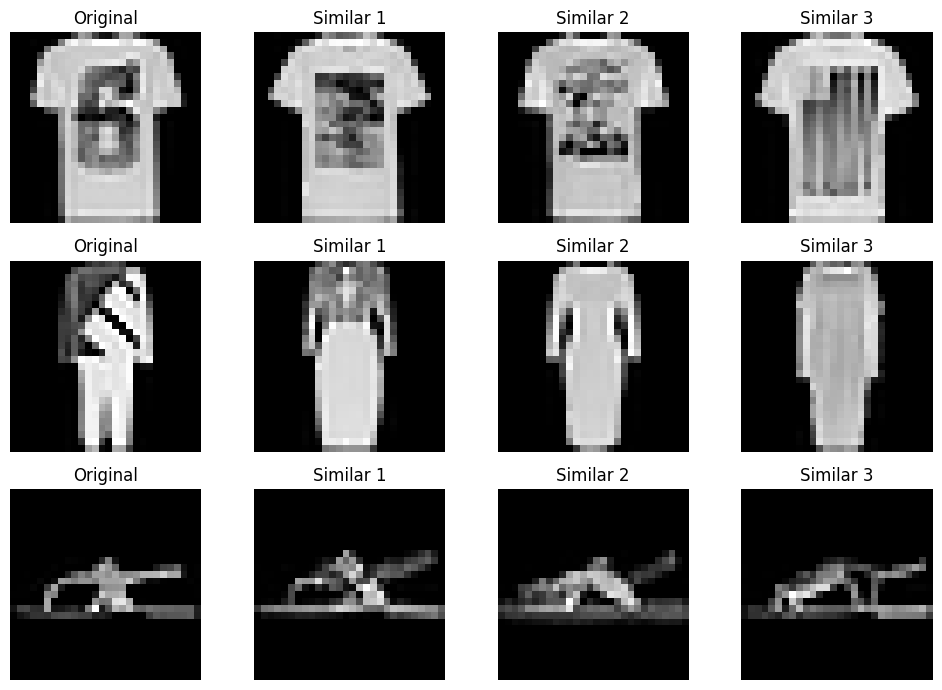

In [46]:
np.random.seed(7)
selected_indices = np.random.choice(x_test.shape[0], 3, replace=False)
similar_images_indices = find_similar_images(encoded_imgs_flatten, selected_indices)
display_similar_images(x_test, selected_indices, similar_images_indices)